# Documentation of the project Interaction by Facial Expressions
**Group members:** Lea Krawczyk, Thi Mai Linh Nguyen, Sebastian Vittinghoff

# Switching to MediaPipe (20.12.2023)
After running into issues with the inaccuracy of Dlib when detecting which eye is closed we decided to try another model: MediaPipe. Mediapipe was developed by Google and is an open-source framework that provides tools for landmark estimation. While both landmark detection and estimation identify key points on the face, landmark estimation is more precise. It provides more information about the spacial information of these points. Landmark detection on the other hand only detects if the points are on the face. Apart from a different process to analyze the face, MediaPipe also provides more than 468 landmark points.

Another factor why MediaPipe is more precise is the attention mechanism. This is a technique modeled after the cognitive learning process of humans. The gist of it is that by selectively focusing on relevant features, the attention model can filter out irrelevant information, enabling in this case MediaPipe to prioritize the analysis of critical details.

An important factor (though more of an added benefit than a deciding factor) is the real-time compatibility. MediaPipe is already quite lightweight making it ideal to take in our webcam inputs. This compatibility ensures that the attention model's precise analysis can be seamlessly integrated into our interactive application, where fast responses are crucial.

| Dlib                                     | MediaPipe                         |
|------------------------------------------|-----------------------------------|
| 68 landmark points                       | approx. 468 landmark points       |
| landmark detection                       | landmark estimation               |
| not optimized for real-time applications | real-time multimedia applications |
|                                          | attention mechanism               |

# New Interactions
Since changing our goal to only using facial expressions as interactions we also needed to adjust our commands: 

### Navigate through the page:

* Scroll to the next area: tilt your head to the right 
* Scroll to the previous area: tilt your head to the left 

### Navigate the carousel:

* Go to the next photo: Close your right eye
* Go to the previous photo: Close your left eye 

### Navigate the filters:
* Select filter or undo: tilt your head down to go to the next filter, tilt your head up to go to the previous filter 
* Apply filter or undo: close both of your eyes once

We also started thinking about the navigation a little more. For the user to use the application more effortlessly and with less inaccuracies, we decided to add a "focus mode". This was inspired by the already existing accessibility guideline Tab order. It says that "The tab order should follow the visual flow of the page: left to right, top to bottom – header first, then main navigation, then page navigation (if present), and finally the footer." [source](https://www.csun.edu/universal-design-center/web-accessibility-criteria-tab-order). This guideline exists for users who are not able to navigate a page with a mouse/trackpad but rely only on keyboard functions. Since we do not want users to rely on any periphery, we wanted to use this guideline with our facial expression commands. 
We already split the application into logically ordered sections, so now we wanted to have two navigation modes, navigate within the application and within the section. To achieve this our plan was to lock in on a specific section via a command. The first idea we had was to blink twice to lock and unlock the focus mode. Once unlocked the user should be able to navigate the application and jump from section to section by tilting the head. If locked, the user should be able to use a specific set of commands only within the section. This way we can also reuse the Head Pose Estimation as a command. The guideline says that there must be a visible tab indication to show the current position of the tab focus. We implemented this through borders with a changing color.

# Head Pose Estimation
In addition to Eye Blink Detection, we also considered including head rotations and tilting of the head as further interactions. After some research, a [source](https://medium.com/@susanne.thierfelder/head-pose-estimation-with-mediapipe-and-opencv-in-javascript-c87980df3acb) proved to be very useful, as it referenced other sources. This provided an example with which the basic principle could be understood very clearly. However, as the [example](https://github.com/niconielsen32/ComputerVision/blob/master/headPoseEstimation.py) is far more complex and performs 3D calculations that are not required, we have worked on our own, simpler solution. The calculations of our algorithm are based on simple 2D calculations that use the landmark coordinates provided by MediaPipe. For example, the coordinates of the bounding box (around the head area) are calculated using the landmark coordinates. This bounding box is then used to determine the rotation and tilt of the head.

## Bounding Box
To calculate the bounding box, all X and Y coordinates of the landmarks are first used to calculate all absolute coordinates based on the width and height of the image. The min or max value for the X and Y coordinates is then determined. The bounding box can then be drawn from these calculated values.


2024-02-16 20:14:45.383780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1708110891.400626       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


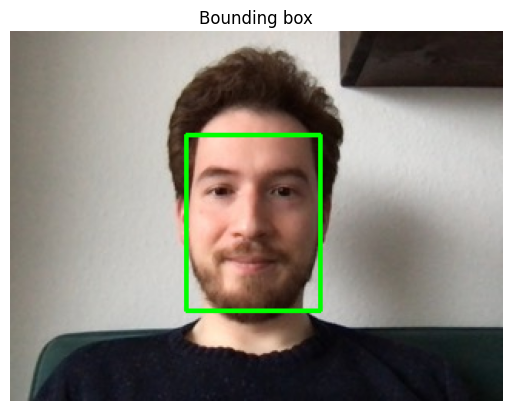

In [1]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

filename = "./assets/head-pose-neutral.jpeg"
image = cv2.imread(filename)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image_height, image_width, _ = image.shape
results = face_mesh.process(image)
face_landmarks = results.multi_face_landmarks[0]

# Calculate the absolute x- and y-coordinates for all landmarks
x_coordinates = [int(landmark.x * image_width) for landmark in face_landmarks.landmark]
y_coordinates = [int(landmark.y * image_height) for landmark in face_landmarks.landmark]

# Determine the min and max values for the x- and y-coordinates of the bounding box
bbox = (min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates))

# Draw bounding box
cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

# The code that follows is purely for plotting purposes.
plt.imshow(image)
plt.title('Bounding box')
plt.axis('off')
plt.show()

### Cross
We have also drawn a cross in the bounding box. This helped us to optimize the threshold values, which will be mentioned later. This allowed us to quickly determine how far we moved away from the origin of the center of the eye or the tip of the nose. To do this, the origin of the bounding box must also be calculated.


I0000 00:00:1708110891.814324       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine


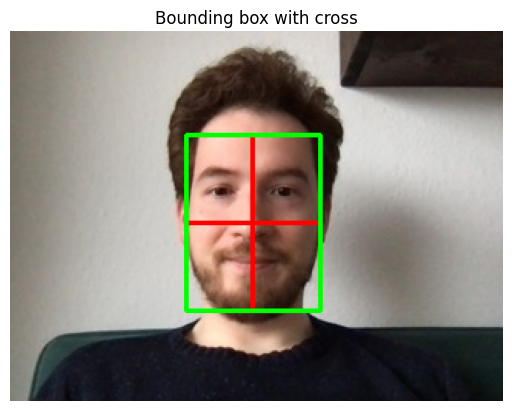

In [2]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

filename = "./assets/head-pose-neutral.jpeg"
image = cv2.imread(filename)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image_height, image_width, _ = image.shape
results = face_mesh.process(image)
face_landmarks = results.multi_face_landmarks[0]

# Calculate the absolute x- and y-coordinates for all landmarks
x_coordinates = [int(landmark.x * image_width) for landmark in face_landmarks.landmark]
y_coordinates = [int(landmark.y * image_height) for landmark in face_landmarks.landmark]

# Determine the min and max values for the x- and y-coordinates of the bounding box
bbox = (min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates))


def calculate_center_of_bounding_box(bounding_box: tuple[int, int, int, int]) -> tuple[int, int]:
    return (bounding_box[0] + (bounding_box[2] - bounding_box[0]) // 2,
            bounding_box[1] + (bounding_box[3] - bounding_box[1]) // 2)


center_of_bbox = calculate_center_of_bounding_box(bbox)

# Draw vertical line of the cross
cv2.line(image, (center_of_bbox[0], bbox[1]), (center_of_bbox[0], bbox[3]), (255, 0, 0), 2)
# Draw horizontal line of the cross
cv2.line(image, (bbox[0], center_of_bbox[1]), (bbox[2], center_of_bbox[1]), (255, 0, 0), 2)

# Draw bounding box
cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

# The code that follows is purely for plotting purposes.
plt.imshow(image)
plt.title('Bounding box with cross')
plt.axis('off')
plt.show()

## Landmarks
To calculate the measurement coordinates, we use 3 landmarks (outer corner of the left eye, outer corner of the right eye and the tip of the nose). In order for further calculations to be performed on the landmarks, the absolute X and Y coordinates must be calculated based on the width and height of the image.


I0000 00:00:1708110892.133357       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine


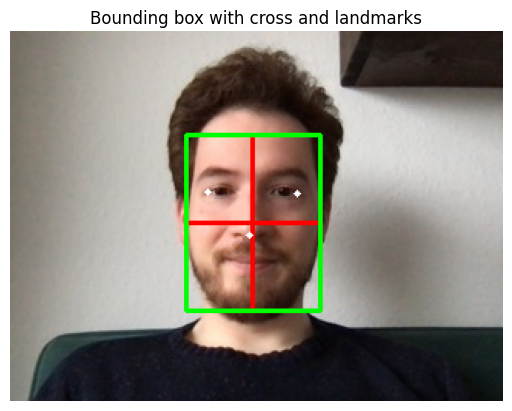

In [3]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt

OUTER_CORNER_OF_THE_LEFT_EYE = 33
OUTER_CORNER_OF_THE_RIGHT_EYE = 263
TIP_OF_THE_NOSE = 1

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

filename = "./assets/head-pose-neutral.jpeg"
image = cv2.imread(filename)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image_height, image_width, _ = image.shape
results = face_mesh.process(image)
face_landmarks = results.multi_face_landmarks[0]

# Calculate the absolute x- and y-coordinates for all landmarks
x_coordinates = [int(landmark.x * image_width) for landmark in face_landmarks.landmark]
y_coordinates = [int(landmark.y * image_height) for landmark in face_landmarks.landmark]

# Determine the min and max values for the x- and y-coordinates of the bounding box
bbox = (min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates))


def calculate_center_of_bounding_box(bounding_box: tuple[int, int, int, int]) -> tuple[int, int]:
    return (bounding_box[0] + (bounding_box[2] - bounding_box[0]) // 2,
            bounding_box[1] + (bounding_box[3] - bounding_box[1]) // 2)


center_of_bbox = calculate_center_of_bounding_box(bbox)


def determine_coordinates(landmark, img_width: int, img_height: int) -> tuple[int, int]:
    return int(landmark.x * img_width), int(landmark.y * img_height)


# Calculate the absolute x- and y-coordinates for the left eye
left_eye_landmark = face_landmarks.landmark[OUTER_CORNER_OF_THE_LEFT_EYE]
left_eye_coordinates = determine_coordinates(left_eye_landmark, image_width, image_height)

# Calculate the absolute x- and y-coordinates for the right eye
right_eye_landmark = face_landmarks.landmark[OUTER_CORNER_OF_THE_RIGHT_EYE]
right_eye_coordinates = determine_coordinates(right_eye_landmark, image_width, image_height)

# Calculate the absolute x- and y-coordinates for the nose
nose_landmark = face_landmarks.landmark[TIP_OF_THE_NOSE]
nose_coordinates = determine_coordinates(nose_landmark, image_width, image_height)

# Draw vertical line of the cross
cv2.line(image, (center_of_bbox[0], bbox[1]), (center_of_bbox[0], bbox[3]), (255, 0, 0), 2)
# Draw horizontal line of the cross
cv2.line(image, (bbox[0], center_of_bbox[1]), (bbox[2], center_of_bbox[1]), (255, 0, 0), 2)

# Draw bounding box
cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

# Draw the landmarks for left eye, right eye and nose
cv2.circle(image, left_eye_coordinates, 2, (255, 255, 255), -1)
cv2.circle(image, right_eye_coordinates, 2, (255, 255, 255), -1)
cv2.circle(image, nose_coordinates, 2, (255, 255, 255), -1)

# The code that follows is purely for plotting purposes.
plt.imshow(image)
plt.title('Bounding box with cross and landmarks')
plt.axis('off')
plt.show()

## Calculation of head rotation and tilt of the head
After the absolute coordinates of the landmarks have been calculated, measurement coordinates for the head rotation or tilt can now also be calculated. To do this, the measurement coordinates for the eyes and nose are calculated relative to the bounding box.

### Why relative to the bounding box? 
If the head is not in the center of the image, the origin of the image was used in previous versions. This meant that the calculations were always based on the center of the image. By setting the origin in the bounding box, the head can now be at the top, right, bottom or left of the camera.


I0000 00:00:1708110892.455183       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine


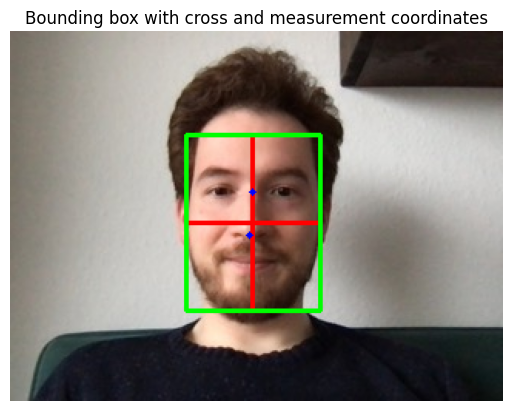

In [4]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt

OUTER_CORNER_OF_THE_LEFT_EYE = 33
OUTER_CORNER_OF_THE_RIGHT_EYE = 263
TIP_OF_THE_NOSE = 1

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)

filename = "./assets/head-pose-neutral.jpeg"
image = cv2.imread(filename)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image_height, image_width, _ = image.shape
results = face_mesh.process(image)
face_landmarks = results.multi_face_landmarks[0]

# Calculate the absolute x- and y-coordinates for all landmarks
x_coordinates = [int(landmark.x * image_width) for landmark in face_landmarks.landmark]
y_coordinates = [int(landmark.y * image_height) for landmark in face_landmarks.landmark]

# Determine the min and max values for the x- and y-coordinates of the bounding box
bbox = (min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates))


def calculate_center_of_bounding_box(bounding_box: tuple[int, int, int, int]) -> tuple[int, int]:
    return (bounding_box[0] + (bounding_box[2] - bounding_box[0]) // 2,
            bounding_box[1] + (bounding_box[3] - bounding_box[1]) // 2)


center_of_bbox = calculate_center_of_bounding_box(bbox)


def determine_coordinates(landmark, img_width: int, img_height: int) -> tuple[int, int]:
    return int(landmark.x * img_width), int(landmark.y * img_height)


# Calculate the absolute x- and y-coordinates for the left eye
left_eye_landmark = face_landmarks.landmark[OUTER_CORNER_OF_THE_LEFT_EYE]
left_eye_coordinates = determine_coordinates(left_eye_landmark, image_width, image_height)

# Calculate the absolute x- and y-coordinates for the right eye
right_eye_landmark = face_landmarks.landmark[OUTER_CORNER_OF_THE_RIGHT_EYE]
right_eye_coordinates = determine_coordinates(right_eye_landmark, image_width, image_height)

# Calculate the absolute x- and y-coordinates for the nose
nose_landmark = face_landmarks.landmark[TIP_OF_THE_NOSE]
nose_coordinates = determine_coordinates(nose_landmark, image_width, image_height)


def calculate_bounding_box_size(bounding_box: tuple[int, int, int, int]):
    return bounding_box[2] - bounding_box[0], bounding_box[3] - bounding_box[1]


def calculate_position_relative_to_bounding_box(
        bounding_box: tuple[int, int, int, int],
        obj: tuple[int, int]
) -> tuple[float, float]:
    center_of_bounding_box = calculate_center_of_bounding_box(bounding_box)
    bounding_box_width, bounding_box_height = calculate_bounding_box_size(bounding_box)

    relative_x = (obj[0] - center_of_bounding_box[0]) / bounding_box_width
    relative_y = (center_of_bounding_box[1] - obj[1]) / bounding_box_height
    return relative_x, relative_y


# Calculate the measurement coordinates for the eyes
eyes = ((left_eye_coordinates[0] + right_eye_coordinates[0]) // 2,
        (left_eye_coordinates[1] + right_eye_coordinates[1]) // 2)
eyes_x, _ = calculate_position_relative_to_bounding_box(bbox, eyes)

# Calculate the measurement coordinates for the nose
_, nose_y = calculate_position_relative_to_bounding_box(bbox, nose_coordinates)

# Draw vertical line of the cross
cv2.line(image, (center_of_bbox[0], bbox[1]), (center_of_bbox[0], bbox[3]), (255, 0, 0), 2)
# Draw horizontal line of the cross
cv2.line(image, (bbox[0], center_of_bbox[1]), (bbox[2], center_of_bbox[1]), (255, 0, 0), 2)

# Draw bounding box
cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

# Draw the measurement coordinates
cv2.circle(image, tuple(int(x) for x in eyes), 2, (0, 0, 255), -1)
cv2.circle(image, tuple(int(x) for x in nose_coordinates), 2, (0, 0, 255), -1)

# The code that follows is purely for plotting purposes.
plt.imshow(image)
plt.title('Bounding box with cross and measurement coordinates')
plt.axis('off')
plt.show()

## Determination of head rotation and tilt of the head
To ensure that the head rotation and tilt of the head can be optimally determined, slight shifts must be corrected using so-called threshold values. As mentioned above, these were repeatedly optimized over time with the help of the cross in the bounding box and console logs. The positions can then be read off as on a coordinate system using simple comparison operations. To determine the head rotation (X-axis), for example, the measurement coordinate of the eyes is used to check how far they have moved to the left or right from the origin. To determine the tilt of the head (Y-axis), the measurement coordinate of the nose is used to check how far it has moved up or down from the origin.


I0000 00:00:1708110892.748011       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine


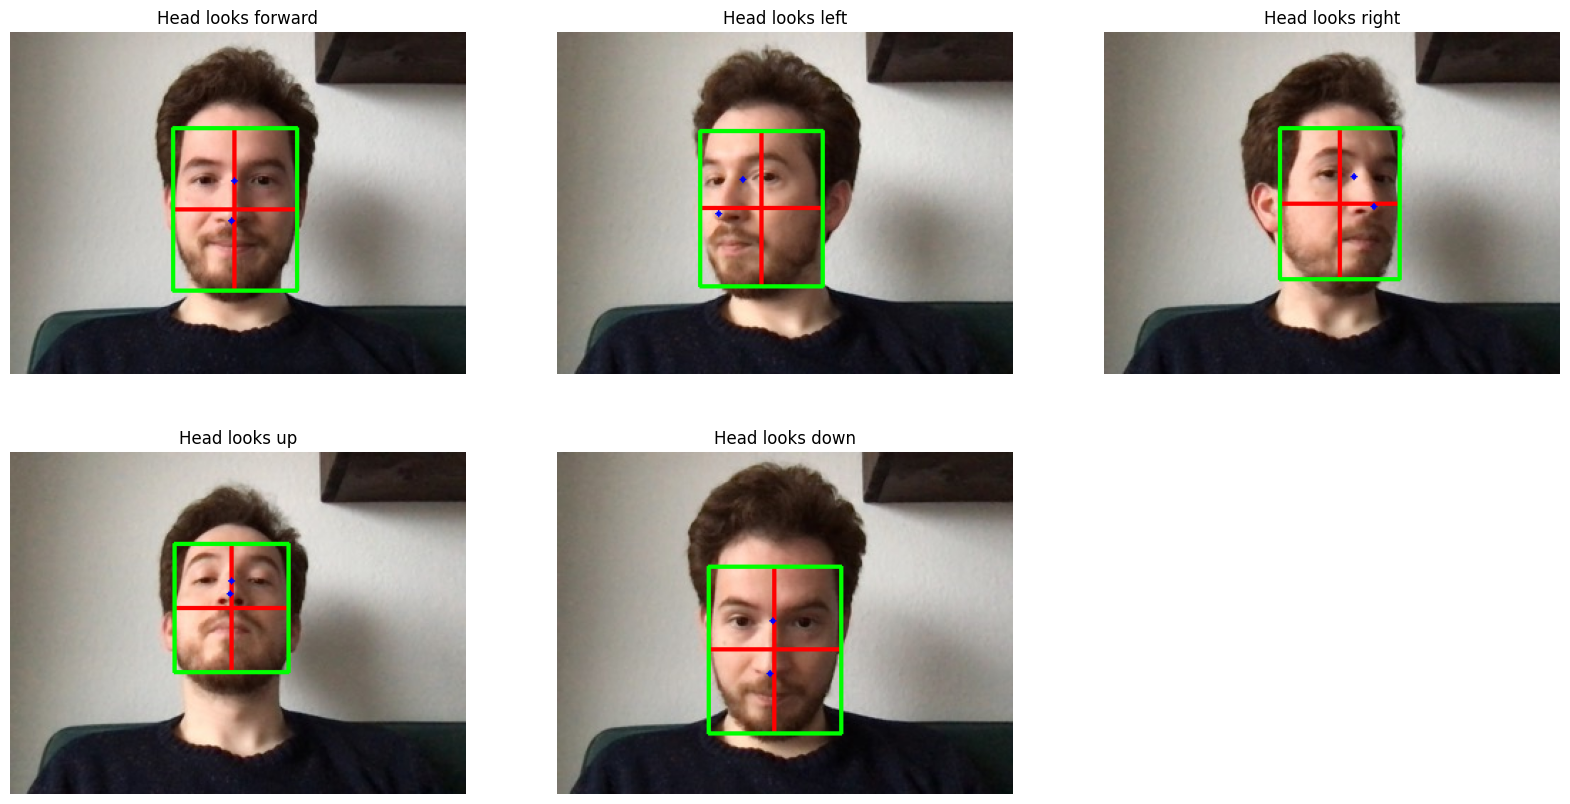

In [5]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt

OUTER_CORNER_OF_THE_LEFT_EYE = 33
OUTER_CORNER_OF_THE_RIGHT_EYE = 263
TIP_OF_THE_NOSE = 1

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5)


def calculate_center_of_bounding_box(bounding_box: tuple[int, int, int, int]) -> tuple[int, int]:
    return (bounding_box[0] + (bounding_box[2] - bounding_box[0]) // 2,
            bounding_box[1] + (bounding_box[3] - bounding_box[1]) // 2)


def determine_coordinates(landmark, img_width: int, img_height: int) -> tuple[int, int]:
    return int(landmark.x * img_width), int(landmark.y * img_height)


def calculate_bounding_box_size(bounding_box: tuple[int, int, int, int]):
    return bounding_box[2] - bounding_box[0], bounding_box[3] - bounding_box[1]


def calculate_position_relative_to_bounding_box(
        bounding_box: tuple[int, int, int, int],
        obj: tuple[int, int]
) -> tuple[float, float]:
    center_of_bounding_box = calculate_center_of_bounding_box(bounding_box)
    bounding_box_width, bounding_box_height = calculate_bounding_box_size(bounding_box)

    relative_x = (obj[0] - center_of_bounding_box[0]) / bounding_box_width
    relative_y = (center_of_bounding_box[1] - obj[1]) / bounding_box_height
    return relative_x, relative_y


def determine_direction(eyes_pos: float, nose_pos: float, eyes_threshold=0.05, nose_threshold=0.075) -> str:
    if eyes_pos < -eyes_threshold:
        return "Head looks left"
    elif eyes_pos > eyes_threshold:
        return "Head looks right"
    elif nose_pos > nose_threshold:
        return "Head looks up"
    elif nose_pos < -nose_threshold:
        return "Head looks down"
    else:
        return "Head looks forward"


def detect_head_pose(image: cv2.typing.MatLike) -> tuple[cv2.typing.MatLike, str]:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_height, image_width, _ = image.shape
    results = face_mesh.process(image)
    face_landmarks = results.multi_face_landmarks[0]

    # Calculate the absolute x- and y-coordinates for all landmarks
    x_coordinates = [int(landmark.x * image_width) for landmark in face_landmarks.landmark]
    y_coordinates = [int(landmark.y * image_height) for landmark in face_landmarks.landmark]

    # Determine the min and max values for the x- and y-coordinates of the bounding box
    bbox = (min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates))

    center_of_bbox = calculate_center_of_bounding_box(bbox)

    # Calculate the absolute x- and y-coordinates for the left eye
    left_eye_landmark = face_landmarks.landmark[OUTER_CORNER_OF_THE_LEFT_EYE]
    left_eye_coordinates = determine_coordinates(left_eye_landmark, image_width, image_height)

    # Calculate the absolute x- and y-coordinates for the right eye
    right_eye_landmark = face_landmarks.landmark[OUTER_CORNER_OF_THE_RIGHT_EYE]
    right_eye_coordinates = determine_coordinates(right_eye_landmark, image_width, image_height)

    # Calculate the absolute x- and y-coordinates for the nose
    nose_landmark = face_landmarks.landmark[TIP_OF_THE_NOSE]
    nose_coordinates = determine_coordinates(nose_landmark, image_width, image_height)

    # Calculate the measurement coordinates for the eyes
    eyes = ((left_eye_coordinates[0] + right_eye_coordinates[0]) // 2,
            (left_eye_coordinates[1] + right_eye_coordinates[1]) // 2)
    eyes_x, _ = calculate_position_relative_to_bounding_box(bbox, eyes)

    # Calculate the measurement coordinates for the nose
    _, nose_y = calculate_position_relative_to_bounding_box(bbox, nose_coordinates)

    # Draw vertical line of the cross
    cv2.line(image, (center_of_bbox[0], bbox[1]), (center_of_bbox[0], bbox[3]), (255, 0, 0), 2)
    # Draw horizontal line of the cross
    cv2.line(image, (bbox[0], center_of_bbox[1]), (bbox[2], center_of_bbox[1]), (255, 0, 0), 2)

    # Draw bounding box
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    # Draw the measurement coordinates
    cv2.circle(image, tuple(int(x) for x in eyes), 2, (0, 0, 255), -1)
    cv2.circle(image, tuple(int(x) for x in nose_coordinates), 2, (0, 0, 255), -1)

    return image, determine_direction(eyes_x, nose_y)


# The code that follows is purely for plotting purposes.
filenames = [
    "./assets/head-pose-neutral.jpeg",
    "./assets/head-pose-rotate-left.jpeg",
    "./assets/head-pose-rotate-right.jpeg",
    "./assets/head-pose-tilt-up.jpeg",
    "./assets/head-pose-tilt-down.jpeg"
]

plt.figure(figsize=(20, 10))

n_col = 3
n_row = len(filenames) // n_col + (len(filenames) % n_col > 0)

for i in range(5):
    image = cv2.imread(filenames[i])

    image, title = detect_head_pose(image)
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.show()

Finally, it must be said that the calculation of the head position can also be carried out with Dlib. In our case, however, we have opted for MediaPipe as we also use this for Eye Blink Detection and therefore do not have to carry out an additional calculation step with Dlib.

## Resources
- [Susanne Thierfelder's "Head Pose Estimation with MediaPipe and OpenCV in Javascript" on Medium](https://medium.com/@susanne.thierfelder/head-pose-estimation-with-mediapipe-and-opencv-in-javascript-c87980df3acb)
- [Nicolai Nielsen's "Real-Time Head Pose Estimation: A Python Tutorial with MediaPipe and OpenCV" on YouTube](https://www.youtube.com/watch?v=-toNMaS4SeQ)
- [Nicolai Nielsen's "Head Pose Estimation Python" on GitHub](https://github.com/niconielsen32/ComputerVision/blob/master/headPoseEstimation.py)


# Gaze Detection 
Because of our research results we wanted to try gaze detection. Although we did not include it in our list of new commands, we thought of it as an alternative for blinking or a different way of navigating that can be used in addition to all the other commands.

This code is based on [Asadullah-Dal17's code](https://github.com/Asadullah-Dal17/Eyes-Position-Estimator-Mediapipe) as well as [Monib Sediqi's](https://kh-monib.medium.com/title-gaze-tracking-with-opencv-and-mediapipe-318ac0c9c2c3). The way this works is that the indices of the eye landmark points are saved which are then used to isolate the eyeshapes and mask the eyes. The images below are what is being used in the analysis. 
<br/>
<div>
    <img src="./assets/eye-shape.png" alt="isolated area of the eyes" width="640"/>
</div>
 
This isolated area of each eye is split into three parts: left, center and right. The gaze of each eye is estimated by analyzing the intensity distribution of the pixels within these isolated areas. This is achieved by calculation the number of black pixels within each of the three parts of the eye region. The gaze is then determined depending on where the most black pixels can be found. If the highest number of black pixels is found within the left part of the eye shape, for example, it indicates that the subject is gazing to the left. The reason for using the black pixels is because the gaze is detected using the pupil, which is black and makes up a significant part of the eye, as seen in the second image above.


In [ ]:
import cv2
import mediapipe as mp
import numpy as np

LEFT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]
RIGHT_EYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

cam = cv2.VideoCapture(0)


def landmarks_detection(img, results, draw=False):
    img_height, img_width = img.shape[:2]
    mesh_coord = [(int(point.x * img_width), int(point.y * img_height)) for point in
                  results.multi_face_landmarks[0].landmark]
    if draw:
        [cv2.circle(img, p, 2, (0, 255, 0), -1) for p in mesh_coord]
    return mesh_coord


def eyesExtractor(img, right_eye_coords, left_eye_coords):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dimension = gray.shape
    mask = np.zeros(dimension, dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(right_eye_coords, dtype=np.int32)], 255)
    cv2.fillPoly(mask, [np.array(left_eye_coords, dtype=np.int32)], 255)

    eyes = cv2.bitwise_and(gray, gray, mask=mask)
    eyes[mask == 0] = 155

    r_max_x = (max(right_eye_coords, key=lambda item: item[0]))[0]
    r_min_x = (min(right_eye_coords, key=lambda item: item[0]))[0]
    r_max_y = (max(right_eye_coords, key=lambda item: item[1]))[1]
    r_min_y = (min(right_eye_coords, key=lambda item: item[1]))[1]

    l_max_x = (max(left_eye_coords, key=lambda item: item[0]))[0]
    l_min_x = (min(left_eye_coords, key=lambda item: item[0]))[0]
    l_max_y = (max(left_eye_coords, key=lambda item: item[1]))[1]
    l_min_y = (min(left_eye_coords, key=lambda item: item[1]))[1]

    cropped_left = eyes[r_min_y: r_max_y, r_min_x: r_max_x]
    cropped_right = eyes[l_min_y: l_max_y, l_min_x: l_max_x]
    return cropped_right, cropped_left


def positionEstimator(cropped_eye):
    h, w = cropped_eye.shape

    gaussain_blur = cv2.GaussianBlur(cropped_eye, (9, 9), 0)
    median_blur = cv2.medianBlur(gaussain_blur, 3)

    ret, threshed_eye = cv2.threshold(median_blur, 130, 255, cv2.THRESH_BINARY)
    piece = int(w / 3)
    left_piece = threshed_eye[0:h, 0:piece]
    center_piece = threshed_eye[0:h, piece: piece + piece]
    right_piece = threshed_eye[0:h, piece + piece:w]

    eye_position, color = pixelCounter(left_piece, center_piece, right_piece)

    return eye_position, color


def pixelCounter(first_piece, second_piece, third_piece):
    left_part = np.sum(first_piece == 0)
    center_part = np.sum(second_piece == 0)
    right_part = np.sum(third_piece == 0)
    eye_parts = [left_part, center_part, right_part]

    max_index = eye_parts.index(max(eye_parts))
    pos_eye = ''
    if max_index == 0:
        pos_eye = 'LEFT'
        color = [(0, 0, 0), (0, 0, 255)]
    elif max_index == 1:
        pos_eye = 'CENTER'
        color = [(150, 0, 50), (255, 0, 128)]
    elif max_index == 2:
        pos_eye = 'RIGHT'
        color = [(75, 75, 75), (79, 100, 9)]
    else:
        pos_eye = "Closed"
        color = [(75, 75, 75), (79, 100, 9)]
    return pos_eye, color


def colorBackgroundText(img, text, font, fontScale, textPos, textThickness=1, textColor=(0, 255, 0), bgColor=(0, 0, 0),
                        pad_x=3, pad_y=3):
    (t_w, t_h), _ = cv2.getTextSize(text, font, fontScale, textThickness)
    x, y = textPos
    cv2.rectangle(img, (x - pad_x, y + pad_y), (x + t_w + pad_x, y - t_h - pad_y), bgColor, -1)
    cv2.putText(img, text, textPos, font, fontScale, textColor, textThickness)
    return img


with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    while True:
        ret, frame = cam.read()
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        results = face_mesh.process(rgb_frame)

        if results.multi_face_landmarks:
            mesh_coords = landmarks_detection(frame, results, False)

            right_coords = [mesh_coords[p] for p in RIGHT_EYE]
            left_coords = [mesh_coords[p] for p in LEFT_EYE]
            crop_right, crop_left = eyesExtractor(frame, left_coords, right_coords)
            eye_position, color = positionEstimator(crop_right)
            colorBackgroundText(frame, f'L: {eye_position}', cv2.FONT_HERSHEY_SIMPLEX, 1.0, (40, 220), 2, color[0],
                                color[1], 8, 8)
            eye_position_left, color = positionEstimator(crop_left)
            colorBackgroundText(frame, f'R: {eye_position_left}', cv2.FONT_HERSHEY_SIMPLEX, 1.0, (40, 320), 2, color[0],
                                color[1], 8, 8)

        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cam.release()
cv2.destroyAllWindows()

After testing this code we found that it works really well but is not suitable for navigation within our application, since we perceived it as really straining on the eyes. Another issue with this was that the fact that you can not see the screen and gaze to the left and right simultaneously. This may lead to the problem that the user keeps gazing in one direction for too long and accidentally triggers the command they wanted to trigger multiple times. Since we also have a Help section on the left hand side of the webcam that the user is supposed to read, which would make them automatically gaze to the left. We also observed the algorith to work better when the user has lighter eyes. Especially in bad lighting situations the gaze direction of dark brown eyes (which appear almost black in the black and white conversion) was barely or not at all detected. 

Because we ran into these problems, we decided against using gaze detection all together. 